# Imports, Definitions & Functions

In [ ]:

import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import rgb2hex
import seaborn as sns
import os
import sys


from scipy.signal import find_peaks
from scipy.signal import savgol_filter
from sklearn.feature_selection import mutual_info_classif 

from sklearn.model_selection import StratifiedKFold, train_test_split
import lightgbm as lgb 

In [ ]:

def time2timestamp(days): 
  ''' 
  takes in a numpy array of representing calendar days of when each sample were collected. 
  return a numpy array of timestamp (integers) to be used an ordinal feature
  ''' 
  counter = 0 
  timestamp = np.zeros_like(days, dtype = int) 
  for i in range(1, len(timestamp)) : 
    if days[i] != days[i-1]: 
      counter += 1 
    timestamp[i] = counter
  return timestamp 


def get_periodic_stats(df):
  '''
  returns 2 Data Frame that has monthly and daily statistics about features 
  derived and added with the feature's name + '_monthly' or '_daily', respectively.
  '''
  month_groubed = df.groupby('month').sum()
  day_groubed = df.groupby('day').sum()
  daily_new_features = day_groubed.transpose()[df.day].transpose().drop(columns = ['month'], axis = 1).astype(dtype = np.int32).rename(columns = lambda x : x + '_daily')
  monthly_new_features = month_groubed.transpose()[df.month].transpose().drop(columns = ['day'], axis = 1).astype(dtype = np.int32).rename(columns = lambda x : x + '_monthly')
  return monthly_new_features.reset_index(drop = True), daily_new_features.reset_index(drop = True)



def get_daily_stats(df, groupby_col):
  day_grouped = df.groupby(groupby_col).sum() 
  daily_new_features = day_grouped.drop(columns = ['month'], axis = 1).astype(dtype = np.float32).rename(columns = lambda x : x + '_daily')
  return daily_new_features

def get_monthly_stats(df, groupby_col):

  month_groubed = df.groupby(groupby_col).sum()
  monthly_new_features = month_groubed.transpose()[df.month].transpose().drop(columns = ['day'], axis = 1).astype(dtype = np.int32).rename(columns = lambda x : x + '_monthly')
  return monthly_new_features.reset_index(drop = True) 


def time2timestamp(df):
  '''
  drops 'test_date' and creates 'month' and 'day' as two separated features
  to separate statstics related per month vs per day. 
  '''
  df = df.copy() 

  df['test_date'] = pd.to_datetime(df.test_date, infer_datetime_format = True) 
  df['month'] = df.test_date.dt.month 
  df['day'] = df.test_date.dt.day
  # df.drop(columns = ['test_date'], inplace = True) 
  return df 

def binarize_features(df):
  df = df.copy() 

  def is_pos(v):
    if isinstance(v, str) :
      return v.lower() in ['yes', 'positive', 'male', '1']
    else: 
      if v : return True 
      else : return False 

  results = df.corona_result.values
  age_above_60 = df.age_60_and_above.values 
  gender = df.gender.values 

  binary_age = [1 if is_pos(age_above_60[i]) else 0 for i in range(len(df)) ]
  binary_results = [1 if is_pos(results[i]) else 0 for i in range(len(df)) ]
  binary_gender = [1 if is_pos(gender[i]) else 0 for i in range(len(df)) ]
  df['corona_result'] = np.array(binary_results, dtype = np.int32)  
  df['age_60_and_above'] = np.array(binary_age, dtype = np.int32)
  df['gender'] = np.array(binary_gender, dtype = np.int32) 

  symptom_features = ['cough', 'fever', 'sore_throat', 'shortness_of_breath', 'head_ache', 'corona_result']
  for f in symptom_features : 
    values = df[f].values
    df[f] = [1 if is_pos(values[i]) else 0 for i in range(len(df))]

  df = df.assign(test_indication = lambda x : x.test_indication == 'Contact with confirmed')
  # may also drop 'gender', 'age_60_and_above' because they have missing values, 
  # but will keep them for now since they will be part of the anlaysis
  # df.drop(columns = ['test_indication'], axis = 1, inplace = True) 
  return df 


def check(df):
  check_missing(df)
  check_duplicates(df) 


def check_missing(df):
  # Columns with missing values
  missing_cols = df.columns[df.isnull().any()]
  # Rows with missing values
  missing_rows = df.index[df.isnull().any(axis=1)]

  #if no missing values
  if len(missing_rows) == 0 and len(missing_cols) == 0: 
      print('No missing values')
  # if there are missing values
  else: 
      print('Number of rows that have missing values', len(missing_rows))
      print('Number of columns that have missing values', len(missing_cols))

def check_duplicates(df) : 
  # Duplicate rows
  duplicate_rows = df[df.duplicated()]

  # if no duplicate rows
  if len(duplicate_rows) == 0:
      print('No duplicate rows')
  # if there are duplicate rows
  else:
      print('Number of duplicate rows', len(duplicate_rows))


In [ ]:
%%capture 

def download_data():
  # download the data file 
  !wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies \
    --no-check-certificate 'https://docs.google.com/uc?export=download&id=1u78Z2-WhhyHzoHf6OtBnxWETnjBw7pg8' \
    -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1u78Z2-WhhyHzoHf6OtBnxWETnjBw7pg8" -O corona_tested_individuals_ver_0083.english.csv && rm -rf /tmp/cookies.txt
  !wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies \
    --no-check-certificate 'https://docs.google.com/uc?export=download&id=1u8R1viz0ty6zR2CuVghRPQrv5XwDNOpk' \
    -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1u8R1viz0ty6zR2CuVghRPQrv5XwDNOpk" -O corona_tested_individuals_ver_006.english.csv && rm -rf /tmp/cookies.txt


# download the data file
download_data()

# Read and merge data

In [ ]:
df = pd.read_csv('corona_tested_individuals_ver_006.english.csv')
df2 = pd.read_csv('isolatedTable.csv')

df = time2timestamp(df) 
df = binarize_features(df) 
d_df = get_daily_stats(df, groupby_col = 'test_date')  

df['test_date'] = pd.to_datetime(df.test_date, infer_datetime_format = True) 
df2['date'] = pd.to_datetime(df2.date, infer_datetime_format = True) 
df2.rename(columns = {'date': 'test_date'}, inplace = True) 

df3 = pd.merge(df, df2, how = 'inner', on = 'test_date')
df4 = pd.merge(df3, d_df, how = 'inner', on = 'test_date')
print(df4.test_date.describe())
df4.drop(columns = ['day_daily', 'test_date' ], inplace = True) 

check_missing(df4) 
df4.shape

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (1,2,3,4,5) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


count                  135060
unique                     32
top       2020-04-01 00:00:00
freq                     8654
first     2020-03-11 00:00:00
last      2020-04-11 00:00:00
Name: test_date, dtype: object
No missing values


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  


(135060, 24)

# EDA

In [ ]:
lightGBM = df

y_features = 'corona_result'
x_features = [col for col in lightGBM.columns if col != y_features]
old_x_features = ['cough','fever','sore_throat','shortness_of_breath','head_ache','age_60_and_above','gender','test_indication']
x_features.remove('month')
x_features.remove('day')
train_df = lightGBM.query("month == 3 and day > 21")
test_df = lightGBM.query("month == 4 and day < 8")
x_train, y_train = train_df[x_features].to_numpy(dtype = np.float32), train_df[y_features].to_numpy(dtype = np.float32)
x_test, y_test = test_df[x_features].to_numpy(dtype = np.float32), test_df[y_features].to_numpy(dtype = np.float32)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((53843, 9), (53843,), (48874, 9), (48874,))

In [ ]:
x_features

['test_date',
 'cough',
 'fever',
 'sore_throat',
 'shortness_of_breath',
 'head_ache',
 'age_60_and_above',
 'gender',
 'test_indication']

In [ ]:

params = {
'num_leaves': 20,
'min_data_in_leaf': 4,
'feature_fraction': 0.2,
'bagging_fraction': 0.8,
'bagging_freq': 5,
'learning_rate': 0.05,
'verbose': 1
}

train_ds = lgb.Dataset(x_train, y_train) 
val_ds = lgb.Dataset(x_test, y_test)
res = {} 
gbm = lgb.train(params, train_ds, num_boost_round = 603,
              valid_sets = [val_ds], valid_names = ['valid'],
              evals_result = res, verbose_eval = 1) 

In [ ]:
res.keys()

dict_keys([])

# Training 2

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_auc_score

# shuffle and split training and test sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=0)

# Learn to predict each class against the other
classifier = OneVsRestClassifier(
    svm.SVC(kernel="linear", probability=True, random_state=10)
)
y_score = classifier.fit(train_x, train_y).decision_function(test_x)
y_score = y_score[..., np.newaxis]
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = 1
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(test_y[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(test_y.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

/usr/local/lib/python3.7/dist-packages/sklearn/multiclass.py:80: UserWarning: Label not 0 is present in all training examples.
  "Label %s is present in all training examples." % str(classes[c])
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_ranking.py:1001: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_ranking.py:1001: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning,


In [ ]:
fpr.keys()

dict_keys([0, 'micro'])

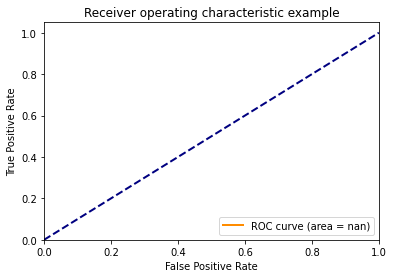

In [ ]:
plt.figure()
lw = 2
plt.plot(
    fpr[0],
    tpr[0],
    color="darkorange",
    lw=lw,
    label="ROC curve (area = %0.2f)" % roc_auc[0],
)
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic example")
plt.legend(loc="lower right")
plt.show()